+ Project originally posted on [inertia7](https://www.inertia7.com/projects/95)
+ [GitHub Repo](https://github.com/raviolli77/machineLearning_breastCancer_Python)

# Introduction to Random Forest

A Random Forest (also known as Random Decision Forest) is a popular supervised classification method used for predictive modeling both for classification and regression problems (for this tutorial, we will be going over Random Forest in the classification context). Essentially a Random Forest is an entire forest of random uncorrelated decision trees, classified as an ensemble method.  

Ensemble methods is the use of multiple learning models to gain better predictive results. For Random Forest, the model creates multiple Decision Trees.

We will be using a famous data set from the UCI Machine Learning Repository, called the [Breast Cancer (Diagnostic)](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) data set which deals with binary classification. 

Familiarity with Classification and Regression Tree (or CART) modeling is expected for this tutorial, a great resource for CART modeling can be found in Chapter 8 of this [book](http://www-bcf.usc.edu/~gareth/ISL/). I will give a brief overview of different CART methodologies culminating to the relevance and preference towards Random Forest, beginning with Decision Trees. 

## Decision Trees

Decision trees are simple but intuitive models that utilize a top down approach where the root node then creates binary splits until a certain criteria is met. More information on its implementation can be found [here](http://scikit-learn.org/stable/modules/tree.html). 

The binary *splitting* of nodes will give an outcome of the predicted value based on the interior nodes leading to the terminal (final) nodes. In the classification context, it will output a predicted target class for each terminal node produced.

Although intuitive, Decision trees do have limitations that prevent it from being a useful model in machine learning applications.

### Limitations to Decision trees

Decision trees tend to have high variance when utilizing different training and test sets of the same data, since they tend to over-fit on the training data leading to poorly performance on unseen data. This limits the usage of Decision trees in predictive modeling, but through ensemble methods we can create models that produce powerful results utilzing the underlying Decision Trees as a basis for the methodology behind ensembles. 

## Bootstrap Aggregating Trees

Through a process known as **B**ootstrap **Agg**regat**ing** (or Bagging), we create an ensemble (forest) of trees where multiple training sets are generated with replacement (meaning data instances or in our case patients can be repeated). Once the training sets are created a CART model is trained on each subsample. 

This approach helps reduce variance by averaging the ensemble's results, creating a majority votes model. Another important feature of Bagging trees is that the model uses the entire feature space when considering node splits. Bagging trees allow the trees to grow without pruning (reducing the tree depth sizes. See [this article](https://www.displayr.com/machine-learning-pruning-decision-trees/) for more details) resulting in high variance but lower bias, which can help in improving predictive power. 

However, a downside to this process is utliziation of the entire feature space since there is a risk of having correlation between trees increasing bias in our model.

### Limitation to Bagging Trees

As stated earlier since each new subsample can include repeated observations we can over-fit our model on the training set. 

The main limitation of Bagging Trees is the use of the entire feature space when creating splits in the trees. If some variables within our feature space are indicative of certain predictions we run the risk of having a forest of correlated trees, thereby increasing bias and reducing variance.  

A simple tweak of Bagging Trees methodology proves advantageous to our models predictive power. 

## Random Forest

Random Forest aims to reduce the previously mentioned correlation by choosing only a subsample of the feature space at each split. Essentially aiming to make the trees de-correlated, along with pruning of trees by setting a stopping criteria for node splits (more on this later). 

The processes outlined in this project are typical of a machine learning project, so I've given an outline of what will be done throughout the tutorial. 

After this tutorial you will be familiar with how to implement (in `python`):

+ Basic exploratory analysis
+ Training and test set creation
+ Model fitting using `sklearn` 
+ Hyperparamter optimization
+ Out of Bag Error Rate
+ Calculating Variable Importance 
+ Test Set calculations
+ Cross Validation
+ ROC Curve Estimation


# Buisness Uses

Random Forest can be used for a plethora of data circumstances including but not limited to:

+ Image Classification
+ Detecting Fraudulent cases in banking systems
+ Recommendation Engines
+ Feature Selection 


# Load Packages

We load our modules into our python environment. I am employing a `Jupyter Notebook` while running inside a `virtualenv` environment (the `requirements.txt` file associated with this repo contains the module information for reproducibility). 

We will be primarily using the [SciPy](https://www.scipy.org/stackspec.html) stack focusing on `pandas`, `matplotlib`, `seaborn` and `sklearn` for this tutorial. 

In [1]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from urllib.request import urlopen 

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

# Load Data
For this section, I'll load the data into a `Pandas` dataframe using `urlopen` from the `urllib.request` module. 

Instead of downloading a `csv`, I started implementing this method (inspired by this [Python Tutorials](https://github.com/JasonFreeberg/PythonTutorials)) where I grab the data straight from the [UCI Machine Learning Database](https://archive.ics.uci.edu/ml/datasets.html) using an http request. 


In [2]:
# Loading data and cleaning dataset
UCI_data_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases\
/breast-cancer-wisconsin/wdbc.data'

I do recommend on keeping a static file for your dataset as well.

Next, I created a list with the appropriate names and set them as the data frame's column names, then I load them unto a `pandas` data frame 

In [3]:
names = ['id_number', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst'] 

dx = ['Benign', 'Malignant']

In [4]:
breast_cancer = pd.read_csv(urlopen(UCI_data_URL), names=names)

## Cleaning
We do some minor cleanage like setting the `id_number` to be the data frame index, along with converting the `diagnosis` to the standard binary 1, 0 representation using the `map()` function. 

In [5]:
# Setting 'id_number' as our index
breast_cancer.set_index(['id_number'], inplace = True) 
# Converted to binary to help later on with models and plots
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M':1, 'B':0})

## Missing Values
Given context of the data set, I know that there is no missing data, but I ran a `for-loop` that checks to see if there was any missing values through each column. Printing the column name and total missing values for that column, iteratively. 

In [6]:
breast_cancer.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

This will be used for the random forest model, where the `id_number` won't be relevant. 

In [7]:
# For later use in CART models
names_index = names[2:]

Let's preview the data set utilizing the `head()` function which will give the first 5 values of our data frame. 

In [8]:
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Next, we'll give the dimensions of the data set; where the first value is the number of patients and the second value is the number of features. 

We print the data types of our data set this is important because this will often be an indicator of missing data, as well as giving us context to anymore data cleanage. 

In [9]:
print("Here's the dimensions of our data frame:\n", 
     breast_cancer.shape)
print("Here's the data types of our columns:\n",
     breast_cancer.dtypes)

Here's the dimensions of our data frame:
 (569, 31)
Here's the data types of our columns:
 diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64

## Class Imbalance

The distribution for `diagnosis` is important because it brings up the discussion of *Class Imbalance* within Machine learning and data mining applications.

*Class Imbalance* refers to when a target class within a data set is outnumbered by the other target class (or classes). This can lead to misleading accuracy metrics, known as [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox), therefore we have to make sure our target classes aren't imblanaced. 

We do so by creating a function that will output the distribution of the target classes. 

**NOTE**: If your data set suffers from class imbalance I suggest reading documentation on upsampling and downsampling.

In [10]:
def print_target_perc(data_frame, col):
    """Function used to print class distribution for our data set"""
    try:
        # If the number of unique instances in column exceeds 20 print warning
        if data_frame[col].nunique() > 20:
            return print('Warning: there are {0} values in `{1}` column which exceed the max of 20 for this function. \
                         Please try a column with lower value counts!'
                         .format(data_frame[col].nunique(), col))
        # Stores value counts
        col_vals = data_frame[col].value_counts().sort_values(ascending=False)
        # Resets index to make index a column in data frame
        col_vals = col_vals.reset_index()

        # Create a function to output the percentage
        f = lambda x, y: 100 * (x / sum(y))
        for i in range(0, len(col_vals['index'])):
            print('`{0}` accounts for {1:.2f}% of the {2} column'\
                  .format(col_vals['index'][i],
                          f(
                              col_vals[col].iloc[i],
                              col_vals[col]),
                          col))
    # try-except block goes here if it can't find the column in data frame
    except KeyError as e:
        raise KeyError('{0}: Not found. Please choose the right column name!'.format(e))


In [11]:
print_target_perc(breast_cancer, 'diagnosis')

`0` accounts for 62.74% of the diagnosis column
`1` accounts for 37.26% of the diagnosis column


Fortunately, this data set does not suffer from *class imbalance*. 

Next we will use a useful function that gives us standard descriptive statistics for each feature including mean, standard deviation, minimum value, maximum value, and range intervals. 

In [12]:
breast_cancer.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


We can see through the maximum row that our data varies in distribution, this will be important when considering classification models. 

*Standardization* is an important requirement for many classification models that should be considered when implementing pre-processing. Some models (like neural networks) can perform poorly if pre-processing isn't considered, so the `describe()` function can be a good indicator for *standardization*. Fortunately Random Forest does not require any pre-processing (for use of categorical data see [sklearn's Encoding Categorical Data](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) section).


# Creating Training and Test Sets

We split the data set into our *training* and *test sets* which will be (pseudo) randomly selected having a 80-20% splt. We will use the training set to train our model along with some optimization, and use our test set as the unseen data that will be a useful final metric to let us know how well our model does. 

When using this method for machine learning always be weary of utilizing your test set when creating models. The issue of data leakage is a serious issue that is common in practice and can result in over-fitting. More on data leakage can be found in this [Kaggle article](https://www.kaggle.com/wiki/Leakage)

In [13]:
feature_space = breast_cancer.iloc[:, breast_cancer.columns != 'diagnosis']
feature_class = breast_cancer.iloc[:, breast_cancer.columns == 'diagnosis']


training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20, 
                                                                    random_state = 42)

**NOTE**: What I mean when I say *pseudo-random* is that we would want everyone who replicates this project to get the same results. So we use a random seed generator and set it equal to a number of our choosing, this will then make the results the same for anyone who uses this generator, awesome for reproducibility.

In [14]:
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel() 
test_class_set = test_class_set.values.ravel() 

# Fitting Random Forest

Now we will create the model no parameter tuning aside from the random seed generator. 

What I mean when I say parameter tuning is different machine learning models utilize various parameters which have to be tuned by the person implementing the algorithm. Here I'll give a brief overview of the parameters I will be tuning in this tutorial:

+ max_depth: the maximum splits for all trees in the forest. 
+ bootstrap: indicating whether or not we want to use bootstrap samples when building trees
+ max_features: the maximum number of features that will be used in the node splitting (the main difference previously mentioned between Bagging trees and Random Forest). Typically we want a value that is less than p, where p is all features in our dataset. 
+ criterion: this is the metric used to asses the stopping criteria for the Decision trees, more on this later 

Once we've instantiated our model we will go ahead and tune our parameters. 

In [15]:
# Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=42)

# Hyperparameters Optimization 

Utilizing the `GridSearchCV` functionality, I create a dictionary with parameters I am looking to optimize to create the best model for our data. Setting the `n_jobs` to 3 tells the grid search to run 3 jobs in parallel reducing the time the function will take to compute the best parameters. I included the timer to help see how long different jobs took, ultimately deciding on using 3 parallel jobs. 


This will help set parameters which I will then use to tune one final paramter; the number of trees in my forest. 

In [16]:
np.random.seed(42)
start = time.time()

param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}
Time taken in grid search:  8.06


Once we are given the best parameter combination, we set the parameters to our model. 

Notice how we didn't utilize the `bootstrap: True` parameter, this will make sense in the following section. 

In [17]:
# Set best parameters given by grid search 
fit_rf.set_params(criterion = 'gini',
                  max_features = 'log2', 
                  max_depth = 3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# Out of Bag Error Rate

Another useful feature of Random Forest is the concept of Out of Bag Error Rate or OOB error rate. When creating the forest, typically only 2/3 of the data is used to train each tree, this gives us 1/3 of unseen data that we can then utilize in a way that is advantageos to our accuracy metrics withou being computationally expensive like cross validation. 

When calculating OOB, two parameters have to be changed as outlined below. Also utilizing a `for-loop` across a multitude of forest sizes, we can calculate the OOB Error rate and use this to asses how many trees are appropriate for our model!

**NOTE**: When calculating the oob score, setting `bootstrap=True` will produce errors, but is necessary for oob_score calculation as stated on this [example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)

For the original analysis I compared *Kth Nearest Neighbor*, *Random Forest*, and *Neural Networks*, so most of the analysis was done to compare across different models. 

In [18]:
fit_rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1, 5):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(training_set, class_set)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

In [19]:
# Convert dictionary to a pandas series for easy plotting 
oob_series = pd.Series(error_rate)

Text(0.5,1,'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

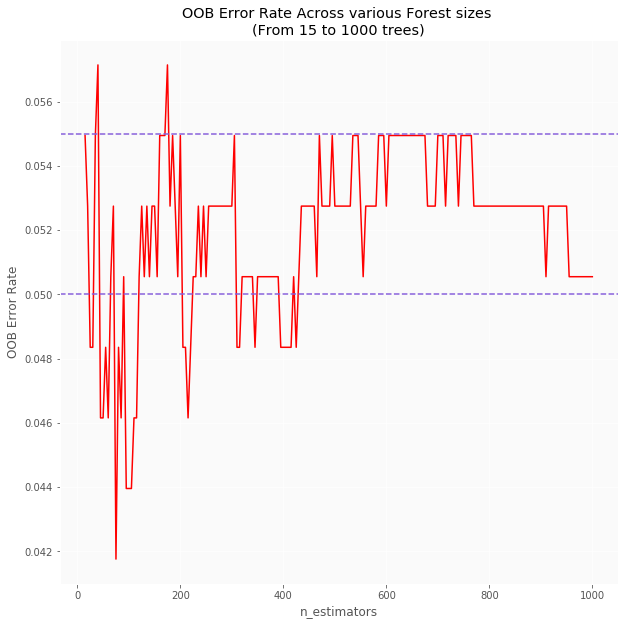

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.055, 
            color='#875FDB',
           linestyle='--')
plt.axhline(0.05, 
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

The OOB error rate starts to oscilate at around 400 trees, so I will go ahead and use my judgement to use 400 trees in my forest. Using the `pandas` series object I can easily find the OOB error rate for the estimator as follows:

In [21]:
print('OOB Error rate for 400 trees is: {0:.5f}'.format(oob_series[400]))

OOB Error rate for 400 trees is: 0.04835


Utilizing the OOB error rate that was created with the model gives us an unbiased error rate. This can be helpful when cross validating and/or hyperparameter optimization prove to be too computationally expensive, since oob can be calculated with the model estimation. 

For the sake of this tutorial I will go over the other traditional methods for machine learning including the training and test error route, along with cross validation metrics.

# Traditional Training and Test Set Split

In order for this methodology to work we will set the number of trees calculated using the OOB error rate, and removing the `warm_start` and `oob_score` parameters. Along with including the `bootstrap` parameter. 

In [22]:
fit_rf.set_params(n_estimators=400,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# Training Algorithm

Next we train the algorithm utilizing the training and target class set we had made earlier. 

In [23]:
fit_rf.fit(training_set, class_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# Variable Importance

Once we have trained the model, we are able to assess this concept of variable importance. A downside to creating ensemble methods with Decision Trees is we lose the interpretability that a single tree gives. A single tree can outline for us important node splits along with variables that were important at each split. 


Forunately ensemble methods utilzing CART models use a metric to evaluate homogeneity of splits. Thus when creating ensembles these metrics can be utilized to give insight to important variables used in the training of the model. Two metrics that are used are `gini impurity` and `entropy`. 

The two metrics vary and from reading documentation online, many people favor `gini impurity` due to the computational cost of `entropy` since it requires calculating the logarithmic function. For more discussion I recommend reading this [article](https://github.com/rasbt/python-machine-learning-book/blob/master/faq/decision-tree-binary.md).

Here we define each metric:

$$Gini\ Impurity = 1 - \sum_i p_i$$

$$Entropy = \sum_i -p_i * \log_2 p_i$$

where $p_i$ is defined as the proportion of subsamples that belong to a certain target class. 

Since we are utilizing the *Gini Impurity*, the impurity measure reaches 0 when all target class labels are the same. 

We are able to access the feature importance of the model and using a helper function to output the importance of our variables in descending order. 

In [24]:
def variable_importance(fit):
    """
    Purpose
    ----------
    Checks if model is fitted CART model then produces variable importance
    and respective indices in dictionary.

    Parameters
    ----------
    * fit:  Fitted model containing the attribute feature_importances_

    Returns
    ----------
    Dictionary containing arrays with importance score and index of columns
    ordered in descending order of importance.
    """
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit))

        # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        KeyError("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [25]:
var_imp_rf = variable_importance(fit_rf)

# Create separate variables for each attribute
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']

In [26]:
def print_var_importance(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on information gain for CART model.
    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
    models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
    based on feature_importances_
    * name_index: Name of columns included in model

    Returns
    ----------
    Prints feature importance in descending order
    """
    print("Feature ranking:")

    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))

In [27]:
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'area_worst' has a Mean Decrease in Impurity of 0.12986
2. The feature 'perimeter_worst' has a Mean Decrease in Impurity of 0.12095
3. The feature 'concave_points_worst' has a Mean Decrease in Impurity of 0.11555
4. The feature 'concave_points_mean' has a Mean Decrease in Impurity of 0.10014
5. The feature 'radius_worst' has a Mean Decrease in Impurity of 0.07805
6. The feature 'concavity_mean' has a Mean Decrease in Impurity of 0.06214
7. The feature 'area_mean' has a Mean Decrease in Impurity of 0.05656
8. The feature 'radius_mean' has a Mean Decrease in Impurity of 0.05457
9. The feature 'perimeter_mean' has a Mean Decrease in Impurity of 0.05174
10. The feature 'area_se' has a Mean Decrease in Impurity of 0.04326
11. The feature 'concavity_worst' has a Mean Decrease in Impurity of 0.03866
12. The feature 'compactness_worst' has a Mean Decrease in Impurity of 0.02033
13. The feature 'compactness_mean' has a Mean Decrease in Impurity of 0.01616
14. The

We can see here that our top 5 variables were `area_worst`, `perimeter_worst`, `concave_points_worst`, `concave_points_mean`, `radius_worst`. 

This can give us great insight for further analysis like [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering), although we won't go into this during this tutorial. This step can help give insight to the practitioner and audience as to what variables played an important part to the predictions generated by the model. 

In our test case, this can help people in the medical field focus on the top variables and their relationship with breast cancer. 

In [28]:
def variable_importance_plot(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.
    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                    models organized by dataframe index
    * indices: 	Organized index of dataframe from largest to smallest
                    based on feature_importances_
    * name_index: Name of columns included in model
    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(name_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(name_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    plt.title('Feature importances for Gradient Boosting Model\
    \nCustomer Churn')
    plt.barh(index,
             importance_desc,
             align="center",
             color = '#875FDB')
    plt.yticks(index,
               feature_space)

    plt.ylim(-1, indices.shape[0])
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

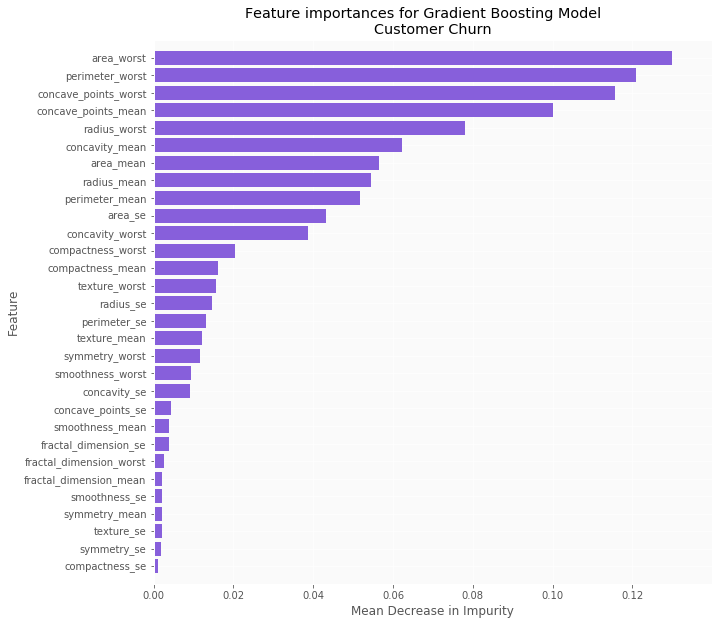

In [29]:
variable_importance_plot(importances_rf, indices_rf, names_index)

The visual helps drive the point of variable importance, since you can clearly see the difference in importance of variables for the ensemble method. Certain cutoff points can be made to reduce the inclusion of features and can help in the accuracy of the model, since we'll be removing what is considered noise within our feature space.


# Cross Validation

*Cross validation* is a powerful tool that is used for estimating the predicitive power of your model, which performs better than the conventional training and test set. What we are doing with *Cross Validation* is we are essentially creating multiple training and test sets, then averaging the scores to give us a less biased metric.

In our case we are creating 10 sets within our data set that calculates the estimations we have done already, but then averages the prediction error to give us a more accurate representation of our model's prediction power, since the model's performance can vary significantly when utilizing different training and test sets.

**Suggested Reading**: For a more concise explanation of *Cross Validation* I recommend reading [An Introduction to Statistical Learnings with Applications in R](http://www-bcf.usc.edu/~gareth/ISL/), specifically chapter 5.1!

## K-Fold Cross Validation

Here we are employing *K-Fold Cross Validation*, more specifically 10 folds. So therefore we are creating 10 subsets of our data where we will be employing the training and test set methodology then averaging the accuracy for all folds to give us our estimatation.

Within a Random Forest context if your data set is significantly large one can choose to not do cross validation and use the OOB error rate as an unbiased metric for computational costs, but for this tutorial I included it to show different accuracy metrics available. 

In [30]:
def cross_val_metrics(fit, training_set, class_set, estimator, print_results = True):
    """
    Purpose
    ----------
    Function helps automate cross validation processes while including
    option to print metrics or store in variable

    Parameters
    ----------
    fit: Fitted model
    training_set:  Data_frame containing 80% of original dataframe
    class_set:     data_frame containing the respective target vaues
                      for the training_set
    print_results: Boolean, if true prints the metrics, else saves metrics as
                      variables

    Returns
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
                from cross validation score's standard deviation)
    """
    my_estimators = {
    'rf': 'estimators_',
    'nn': 'out_activation_',
    'knn': '_fit_method'
    }
    try:
        # Captures whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit))

        # Captures whether the model has been trained
        if not vars(fit)[my_estimators[estimator]]:
            return print("Model does not appear to be trained.")

    except KeyError as e:
        raise("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
              Please refer to function to check `my_estimators` dictionary.".format(estimator))

    n = KFold(n_splits=10)
    scores = cross_val_score(fit,
                         training_set,
                         class_set,
                         cv = n)
    if print_results:
        for i in range(0, len(scores)):
            print("Cross validation run {0}: {1: 0.3f}".format(i, scores[i]))
        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
              .format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2

In [31]:
cross_val_metrics(fit_rf, 
                  training_set, 
                  class_set, 
                  'rf',
                  print_results = True)

Cross validation run 0:  1.000
Cross validation run 1:  0.957
Cross validation run 2:  0.935
Cross validation run 3:  0.935
Cross validation run 4:  0.957
Cross validation run 5:  0.978
Cross validation run 6:  0.933
Cross validation run 7:  0.889
Cross validation run 8:  1.000
Cross validation run 9:  0.889
Accuracy:  0.947 (+/-  0.019)


# Test Set Metrics
Now we will be utilizing the test set that was created earlier to receive another metric for evaluation of our model. Recall the importance of data leakage and that we didn't touch the test set until now, after we had done hyperparamter optimization. 

We create a confusion matrix showcasing the following metrics:

| n = Sample Size | Predicted Benign | Predicted Malignant | 
|-----------------|------------------|---------------------|
| Actual Benign | *True Negative* | *False Positive* | 
| Actual Malignant | *False Negative* | *True Positive* | 

In [32]:
predictions_rf = fit_rf.predict(test_set)

## Confusion Matrix
Here we create a confusion matrix visual with `seaborn` and transposing the matrix when creating the heatmap. 

In [33]:
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

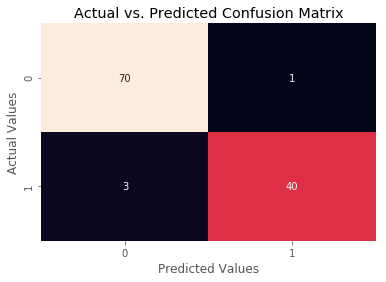

In [34]:
conf_mat = create_conf_mat(test_class_set, predictions_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [35]:
accuracy_rf = fit_rf.score(test_set, test_class_set)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our mean accuracy on the test set:
 0.965


In [36]:
# Here we calculate the test error rate!
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.0351


As you can see we got a very similar error rate for our test set that we did for our OOB, which is a good sign for our model. 

# ROC Curve Metrics

Receiver Operating Characteristc Curve, calculates the False Positive Rates and True Positive Rates across different thresholds . 

We will now graph these calculations, and being located the top left corner of the plot indicates a really ideal model, i.e. a False Positive Rate of 0 and True Positive Rate of 1, whereas an ROC curve that is at a 45 degree is indicative of a model that is essentially randomly guessing. 

We also calculated the Area under the Curve or AUC, the AUC is used as a metric to differentiate the predicion power for those with the disease and those without it. Typically a value closer to one means that our model was able to differentiate correctly from a random sample of the two target classes of two patients with and without the disease.    

In [37]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob = fit_rf.predict_proba(test_set)[:, 1]

fpr2, tpr2, _ = roc_curve(test_class_set,
                          predictions_prob,
                          pos_label = 1)

In [38]:
auc_rf = auc(fpr2, tpr2)

In [39]:
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: 	Array returned from sklearn.metrics.roc_curve for increasing
    false positive rates
    * tpr: 	Array returned from sklearn.metrics.roc_curve for increasing
    true positive rates
    * auc:	Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: 	String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim:		Set upper and lower x-limits
    * ylim:		Set upper and lower y-limits
    """
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        raise("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
              Please refer to function to check `my_estimators` dictionary.".format(estimator))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()


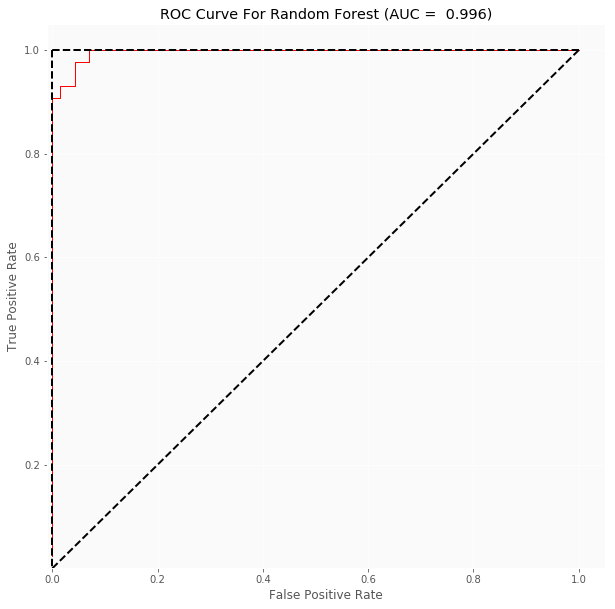

In [40]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

Our model did exceptional with an AUC over .90, now we do a zoomed in view to showcase the closeness our ROC Curve is relative to the ideal ROC Curve. 

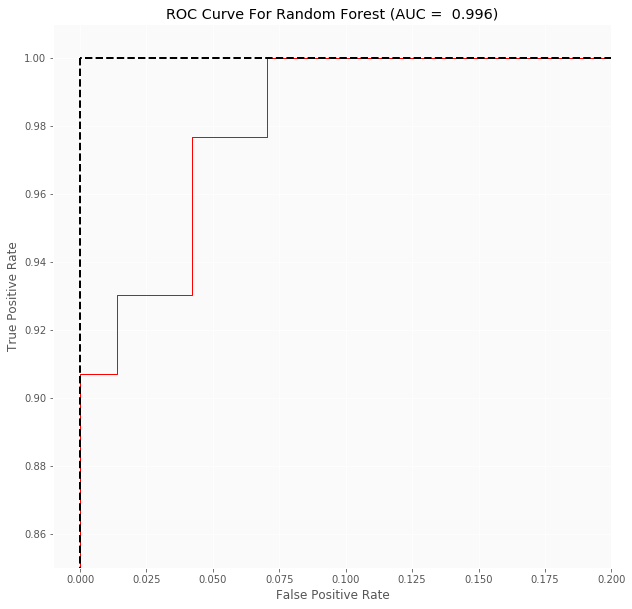

In [41]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf', 
               xlim=(-0.01, 0.2), 
               ylim=(0.85, 1.01))

# Classification Report

The classification report is available through `sklearn.metrics`, this report gives many important classification metrics including:
+ `Precision`: also the positive predictive value, is the number of correct predictions divided by the number of correct predictions plus false positives, so $tp / (tp + fp)$
+ `Recall`: also known as the sensitivity, is the number of correct predictions divided by the total number of instances so $tp / (tp + fn)$ where $fn$ is the number of false negatives
+ `f1-score`: this is defined as the *weighted harmonic mean* of both the precision and recall, where the f1-score at 1 is the best value and worst value at 0, as defined by the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)
+ `support`: number of instances that are the correct target values

Across the board we can see that our model provided great insight into classifying patients based on the FNA scans. Important metrics to consider would be optimzing the *false positive* rate since within this context it would be bad for the model to tell someone that they are cancer free when in reality they have cancer.


In [42]:
def print_class_report(predictions, alg_name):
    """
    Purpose
    ----------
    Function helps automate the report generated by the
    sklearn package. Useful for multiple model comparison

    Parameters:
    ----------
    predictions: The predictions made by the algorithm used
    alg_name: String containing the name of the algorithm used
    
    Returns:
    ----------
    Returns classification report generated from sklearn. 
    """
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions, 
            test_class_set, 
            target_names = dx))

In [43]:
class_report = print_class_report(predictions_rf, 'Random Forest')

Classification Report for Random Forest:
             precision    recall  f1-score   support

     Benign       0.99      0.96      0.97        73
  Malignant       0.93      0.98      0.95        41

avg / total       0.97      0.96      0.97       114



## Metrics for Random Forest

Here I've accumulated the various metrics we used through this tutorial in a simple table! Showcasing the power and effectiveness of Random Forest Modeling. 

| Model | OOB Error Rate | Test Error Rate | Cross Validation Score | AUC | 
|-------|----------------|------------------------|-----------------|-----|
| Random Forest | 0.04835 |  0.0351 | 0.947 (+/-  0.019) | 0.996 | 

# Conclusions

For this tutorial we went through a number of metrics to assess the capabilites of our Random Forest, but this can be taken further when using background information of the data set. Feature engineering would be a powerful tool to extract and move forward into research regarding the important features. As well defining key metrics to utilize when optimizing model paramters. 

There have been advancements with image classification in the past decade that utilize the images intead of extracted features from images, but this data set is a great resource to become with machine learning processes. Especially for those who are just beginning to learn machine learning concepts. If you have any suggestions, recommendations, or corrections please reach out to me. 


